# Title of Your Group Project

This Python notebook serves as a template for your group project for the course "Modeling in Cognitive Science".

This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [1]:
from simulate import simulate
from utils import calculate_stay_probability, plot_stay_probabilities, print_simple_statistics,\
    save_simulated_data

In [2]:
# Run simulation with default parameter and save to csv
seed = 0
task_df_r , agent_r= simulate(agent_type='random', seed=seed)
task_df_mf , agent_mf= simulate(agent_type='model_free', seed=seed)
task_df_mb , agent_mb= simulate(agent_type='model_based', seed=seed)
task_df_hybrid , agent_hybrid= simulate(agent_type='hybrid', seed=seed)
# save_simulated_data(task_df_r, agent_type='random')
# save_simulated_data(task_df_mf, agent_type='model_free')
# save_simulated_data(task_df_mb, agent_type='model_based')
# save_simulated_data(task_df_hybrid, agent_type='hybrid')

### random
common transitions percentage: 69.0 %
rewarded trails percentage: 53.0 %
### model_free
common transitions percentage: 72.5 %
rewarded trails percentage: 42.0 %
### model_based
common transitions percentage: 70.0 %
rewarded trails percentage: 48.0 %
### hybrid
common transitions percentage: 70.0 %
rewarded trails percentage: 50.5 %


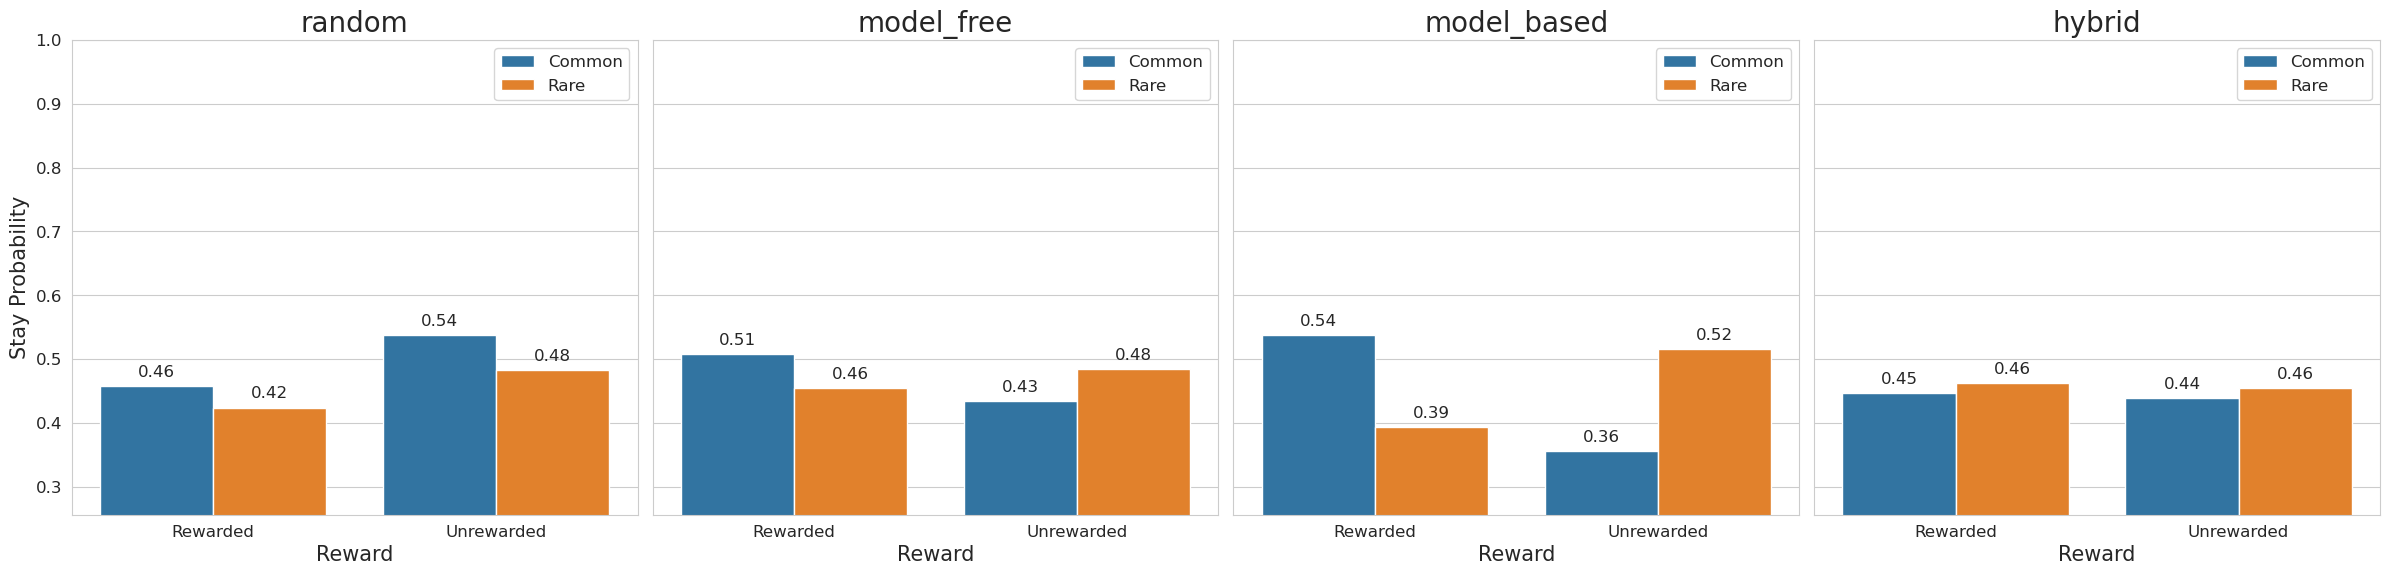

In [3]:

# print q table and transition matrix
# print("q_table model free:\n", agent_mf.q_table)
# print("q_table model based:\n", agent_mb.q_table)
# print("q_table hybrid:\n", agent_hybrid.q_table)
# if hasattr(agent_mb, 'transition_model'):
#     print("transition_matrix model based:\n", agent_mb.transition_model[0])
# if hasattr(agent_hybrid, 'transition_model'):
#     print("transition_matrix hybrid:\n", agent_hybrid.transition_model[0])

# print some statistics 
print_simple_statistics(task_df_r, title='random')
print_simple_statistics(task_df_mf, title='model_free')
print_simple_statistics(task_df_mb, title='model_based')
print_simple_statistics(task_df_hybrid, title='hybrid')

# calculate and plot stay probability
stay_probability_r, _ = calculate_stay_probability(task_df_r)
stay_probability_mf, _ = calculate_stay_probability(task_df_mf)
stay_probability_mb, _ = calculate_stay_probability(task_df_mb)
stay_probability_hybrid, _ = calculate_stay_probability(task_df_hybrid)

fig = plot_stay_probabilities(dfs=[stay_probability_r,
                            stay_probability_mf,
                            stay_probability_mb,
                             stay_probability_hybrid],
                        labels=['random',
                                'model_free',
                                'model_based',
                                'hybrid'])

# display(task_df_extended[['stepOneChoice', 'repeated_stepOneAction', 'repeated_stepOneAction_next','reward', 'common_transition']])


## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [1]:
from simulate import simulate
from utils import calculate_running_step_probabilities, plot_running_step_probabilities,\
     preprocess_human_data, calculate_stay_probability, plot_stay_probabilities,\
        print_simple_statistics, save_simulated_data
import pandas as pd
import os

In [2]:
# parameters
params_model_free = {'alpha': 0.2,
                      'beta': 3,
                      'gamma': 0.9}
params_model_based = {'alpha': 0.2,
                      'beta': 3,
                      'gamma': 0.9}
params_hybrid = {'alpha_1': 0.2,
                 'alpha_2': 0.2,
                 'beta_1': 3,
                 'beta_2': 3,
                 '_lambda': 0,
                 'w': 0.5,
                 'p': 0}

# Run simulation and save to csv
task_df_mf, agent_mf = simulate(agent_type='model_free', params=params_model_free)
task_df_mb, agent_mb = simulate(agent_type='model_based', params=params_model_based)
task_df_hybrid, agent_hybrid = simulate(agent_type='hybrid', params=params_hybrid)
# task_df_random, agent_random = simulate(agent_type='random')
# save_simulated_data(task_df_mf, agent_type='model_free')
# save_simulated_data(task_df_mb, agent_type='model_based')

# load and inspect human data
particepant_data_file = "experiment_data_mj.csv"
file_name = os.path.join("data", "participants", particepant_data_file)
human_data = pd.read_csv(file_name)
# preprocess human data
human_data = preprocess_human_data(human_data)

### Model Free
common transitions percentage: 72.5 %
rewarded trails percentage: 43.0 %
### Model Based
common transitions percentage: 68.0 %
rewarded trails percentage: 48.5 %
### Hybrid
common transitions percentage: 71.0 %
rewarded trails percentage: 54.0 %
### Participant
common transitions percentage: 70.5 %
rewarded trails percentage: 56.99999999999999 %


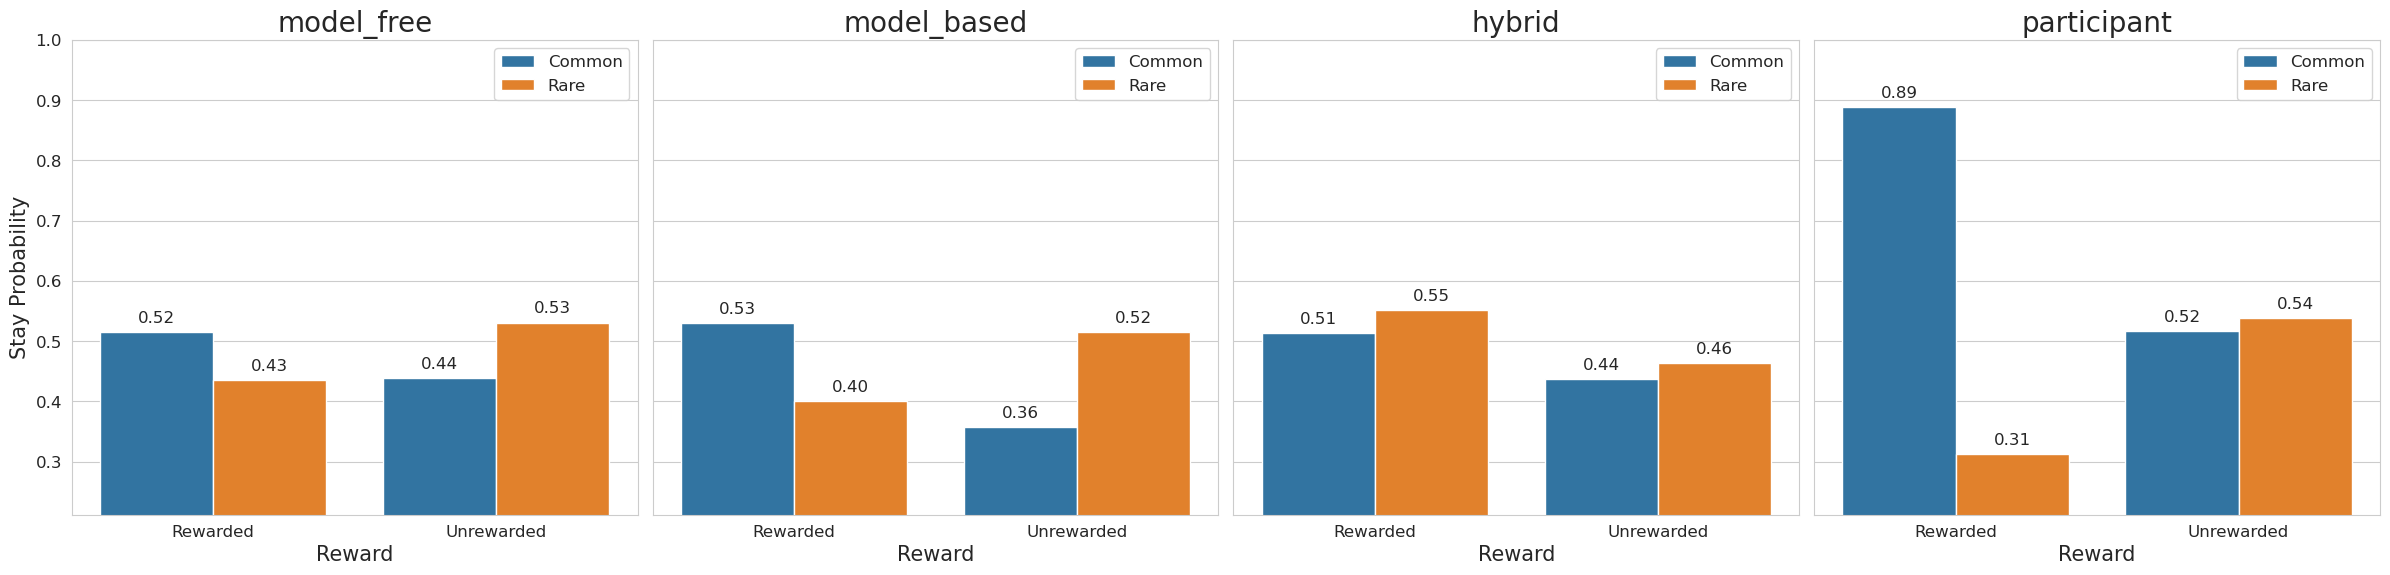

In [3]:
# print some statistics 
print_simple_statistics(task_df_mf, title='Model Free')
print_simple_statistics(task_df_mb, title='Model Based')
print_simple_statistics(task_df_hybrid, title='Hybrid')
print_simple_statistics(human_data, title='Participant')

# calculate and plot stay probability
stay_probability_mf, _ = calculate_stay_probability(task_df_mf)
stay_probability_mb, _ = calculate_stay_probability(task_df_mb)
stay_probability_h, _ = calculate_stay_probability(human_data)
stay_probability_hybrid, _ = calculate_stay_probability(task_df_hybrid)

plot_stay_probabilities(dfs=[stay_probability_mf, stay_probability_mb, stay_probability_hybrid, stay_probability_h],
                        labels=['model_free', 'model_based', 'hybrid', 'participant'])

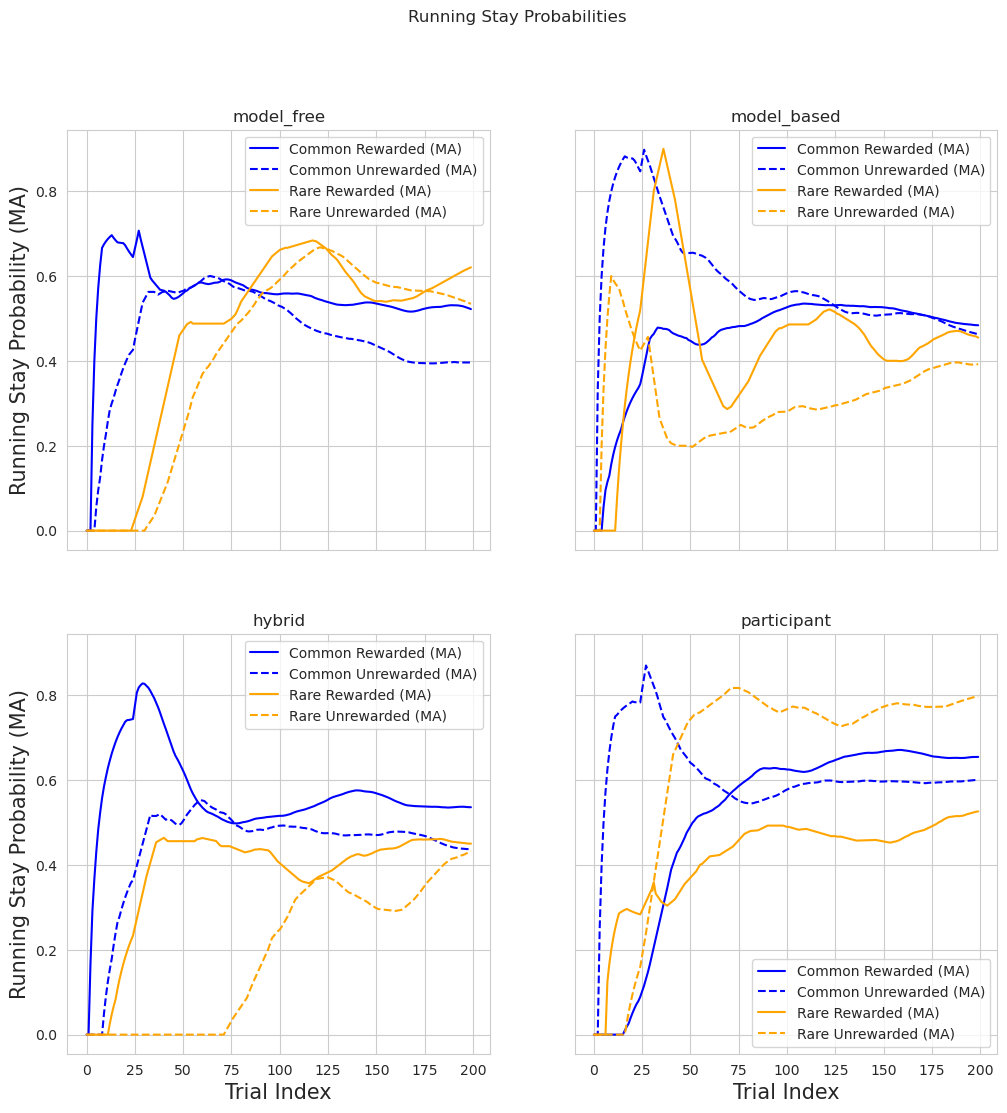

In [6]:
AVERAGE_WINDOW = 25
                      
# Generate behavior from the model free agent
task_df_mf = calculate_running_step_probabilities(task_df_mf)

# Generate behavior from the model based agent
task_df_mb = calculate_running_step_probabilities(task_df_mb)

# Generate behavior from the hybrid agent
task_df_hybrid = calculate_running_step_probabilities(task_df_hybrid)

# Generate behavior from the human data
human_data = calculate_running_step_probabilities(human_data)

# plot the running step probabilities
plot_running_step_probabilities(task_dfs=[task_df_mf, task_df_mb, task_df_hybrid, human_data],
                               labels=['model_free', 'model_based', 'hybrid', 'participant'],
                                window_size=AVERAGE_WINDOW, title='Running Stay Probabilities',
                                max_plots_per_row=2)

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



In [17]:
from simulate import simulate
from parameter_fitting import fit_with_grid_search, log_likelihood, fit_to_average_accumulated_reward, plot_fit_results,\
    fit_with_random_search, get_best_params_and_ll
from utils import preprocess_human_data, calculate_stay_probability, plot_stay_probabilities, print_simple_statistics
from environment import TwoStepEnv
import numpy as np
import pandas as pd
import os
from scipy.stats import uniform
from IPython.display import display

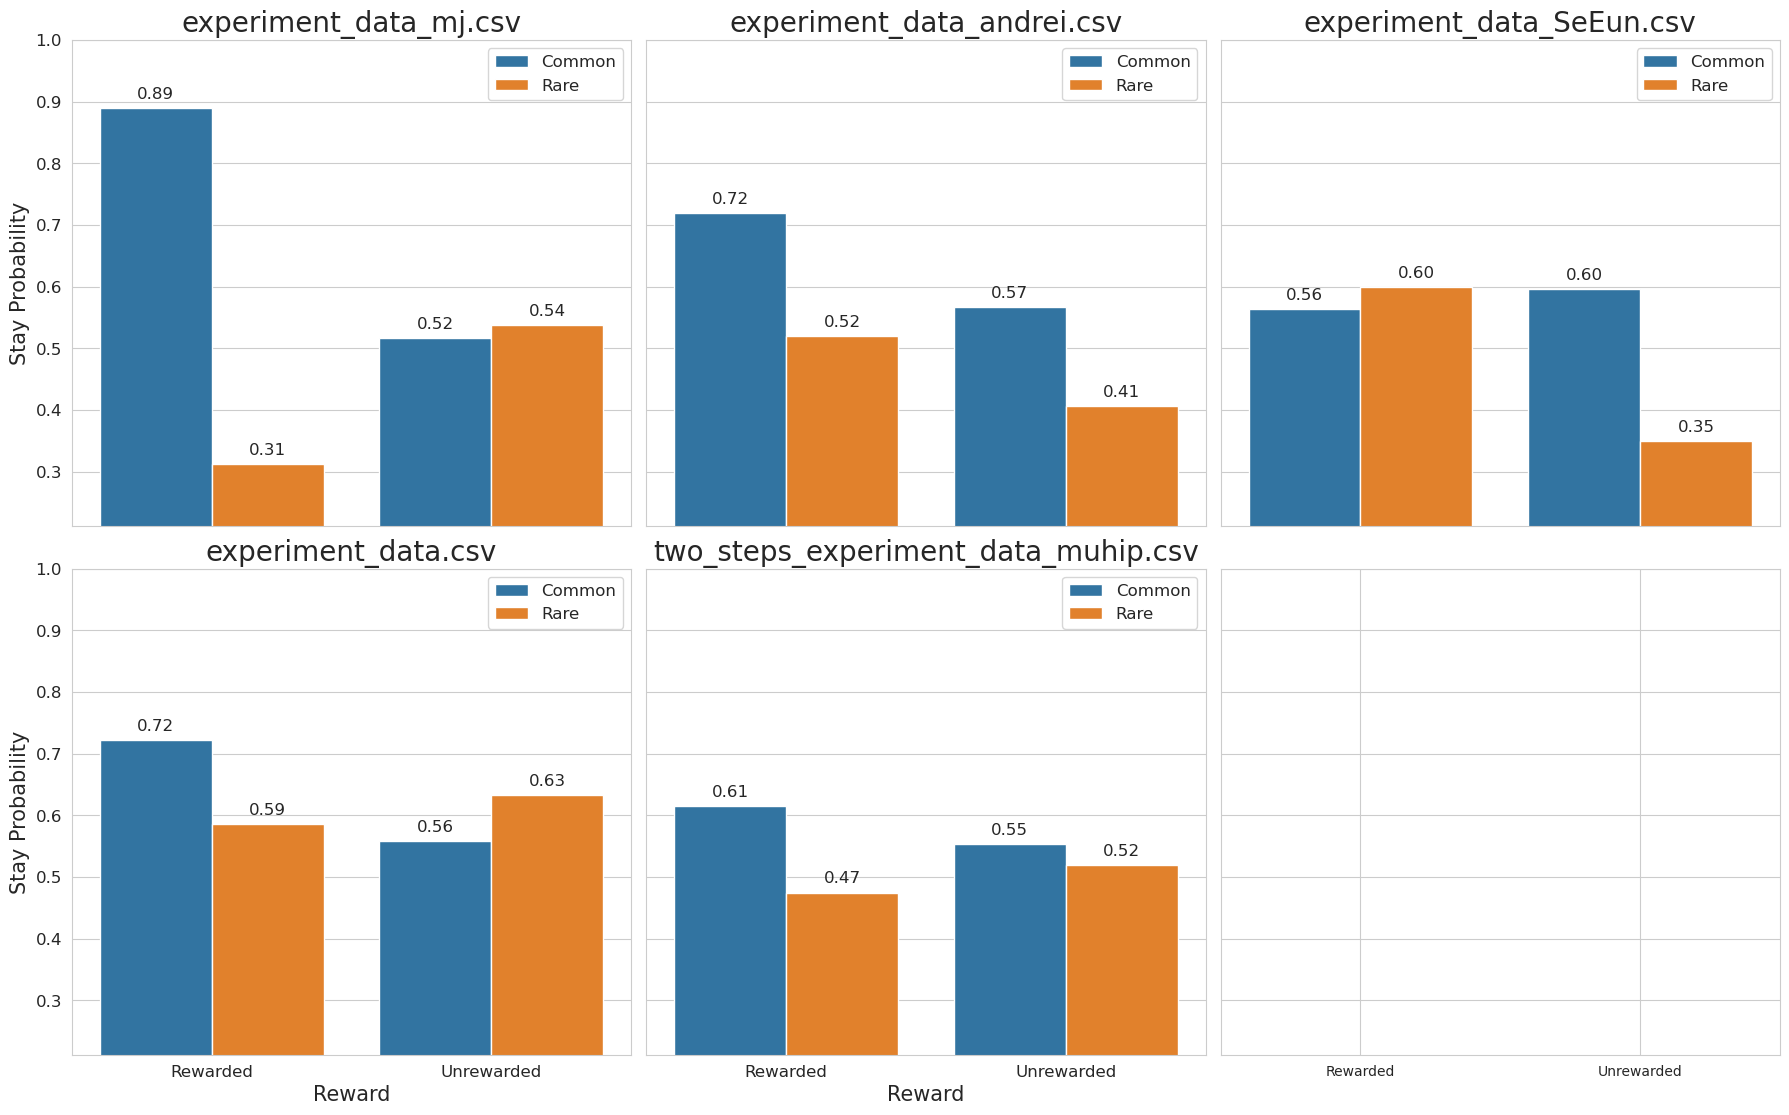

In [5]:
# load and inspect some human data
file_names = ['experiment_data_mj.csv', 'experiment_data_andrei.csv', 
              'experiment_data_SeEun.csv', 'experiment_data.csv', 'two_steps_experiment_data_muhip.csv']
stay_prob_list = []
human_data_list = [] 
for file_name in file_names:
    file_name = os.path.join("data", "participants", file_name)
    human_data = pd.read_csv(file_name)
    human_data = preprocess_human_data(human_data)
    human_data_list.append(human_data)
    
    stay_probability_h, _ = calculate_stay_probability(human_data)
    stay_prob_list.append(stay_probability_h)

plot_stay_probabilities(dfs=stay_prob_list, labels=file_names, max_plots_per_row=3)

In [6]:
# pick a participant to fit the model to
human_data = human_data_list[0]

# fit to average accumulated reward
interpolation_steps = 21
# alpha_space = np.linspace(0.05, 0.5 , interpolation_steps)
# beta_space = np.linspace(2, 6, interpolation_steps)
alpha_space = np.linspace(0, 1 , interpolation_steps)
beta_space = np.linspace(-10, 10, interpolation_steps)
parammeter_space = {'alpha': alpha_space,
                    'beta': beta_space}


consider_both_stages = True

In [7]:
# fit to using log likelihood of choices
fit_results_mb = fit_with_grid_search(parammeter_space, human_data, agent_type='model_based',
                                            consider_both_stages=consider_both_stages)
fit_results_mf = fit_with_grid_search(parammeter_space, human_data, agent_type='model_free',
                                            consider_both_stages=consider_both_stages)


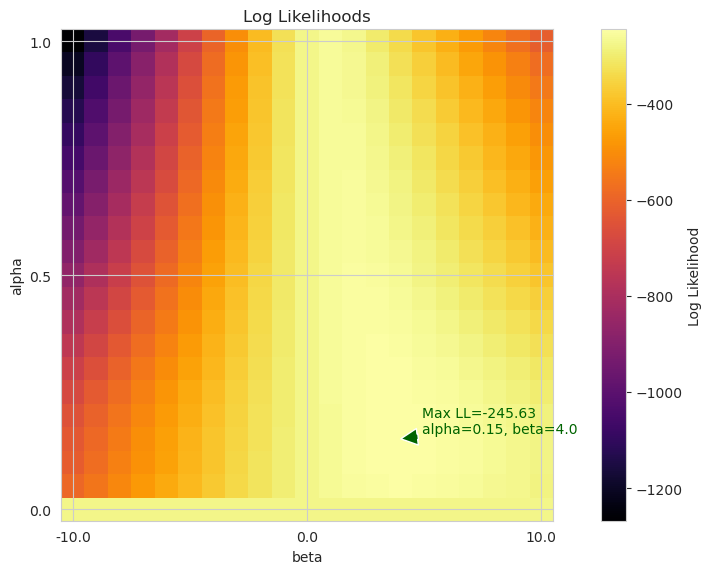

parameter space should be of type dict, provided: <class 'dict'>


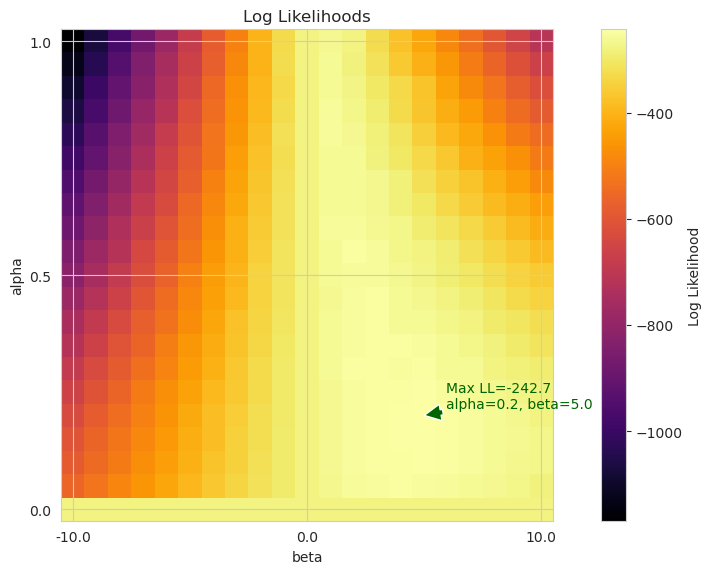

parameter space should be of type dict, provided: <class 'dict'>
best_alpha_mb: 0.15000000000000002, best_beta_mb: 4.0, best_ll_mb: -245.62672544794086
best_alpha_mf: 0.2, best_beta_mf: 5.0, best_ll_mf: -242.70095493486076


In [8]:
# plot fit results
plot_fit_results(fit_results_mb, parammeter_space)
plot_fit_results(fit_results_mf, parammeter_space)

# get the best parameters model based
best_params_mb = np.unravel_index(fit_results_mb.argmax(), fit_results_mb.shape)
best_alpha_mb = alpha_space[best_params_mb[0]]
best_beta_mb = beta_space[best_params_mb[1]]
best_ll_mb = fit_results_mb.max()
print(f'best_alpha_mb: {best_alpha_mb}, best_beta_mb: {best_beta_mb}, best_ll_mb: {best_ll_mb}')
best_params_mb = {'alpha': best_alpha_mb, 'beta': best_beta_mb}

# get the best parameters model free
best_params_mf = np.unravel_index(fit_results_mf.argmax(), fit_results_mf.shape)
best_alpha_mf = alpha_space[best_params_mf[0]]
best_beta_mf = beta_space[best_params_mf[1]]
best_ll_mf = fit_results_mf.max()
print(f'best_alpha_mf: {best_alpha_mf}, best_beta_mf: {best_beta_mf}, best_ll_mf: {best_ll_mf}')
best_params_mf = {'alpha': best_alpha_mf, 'beta': best_beta_mf}

In [15]:
# Fit hybrid model
# Define parameter distributions
param_distributions = {
    'alpha_1': uniform(0, 1),
    'alpha_2': uniform(0, 1),
    'beta_1': uniform(-10, 10),
    'beta_2': uniform(-10, 10),
    '_lambda': uniform(0.0, 1.0),
    'w': uniform(0.0, 1.0),
    'p': uniform(-1, 2),
}

n_iter = 256  # Number of parameter settings that are produced

np.random.seed(None)
random_seed = np.random.randint(0, 1000)

In [9]:
results_df = fit_with_random_search('hybrid', param_distributions, human_data, n_iter, consider_both_stages, seed=random_seed)

In [10]:
best_params_hybrid, best_ll_hybrid = get_best_params_and_ll(results_df)

print("Best fitted parameters:", best_params_hybrid)
print("Best log likelihood:", best_ll_hybrid)

Best fitted parameters: {'_lambda': 0.5120785367501612, 'alpha_1': 0.46730637514690265, 'alpha_2': 0.05411294633288588, 'beta_1': -2.650060434758732, 'beta_2': -1.0955669240149284, 'p': -0.03503905286298248, 'w': 0.8197731684879719}
Best log likelihood: -298.2576681744626


seed: 31
##################################################
seed: 60
##################################################
seed: 5
##################################################
seed: 62
##################################################
seed: 9
##################################################
seed: 55
##################################################
seed: 55
##################################################
seed: 39
##################################################


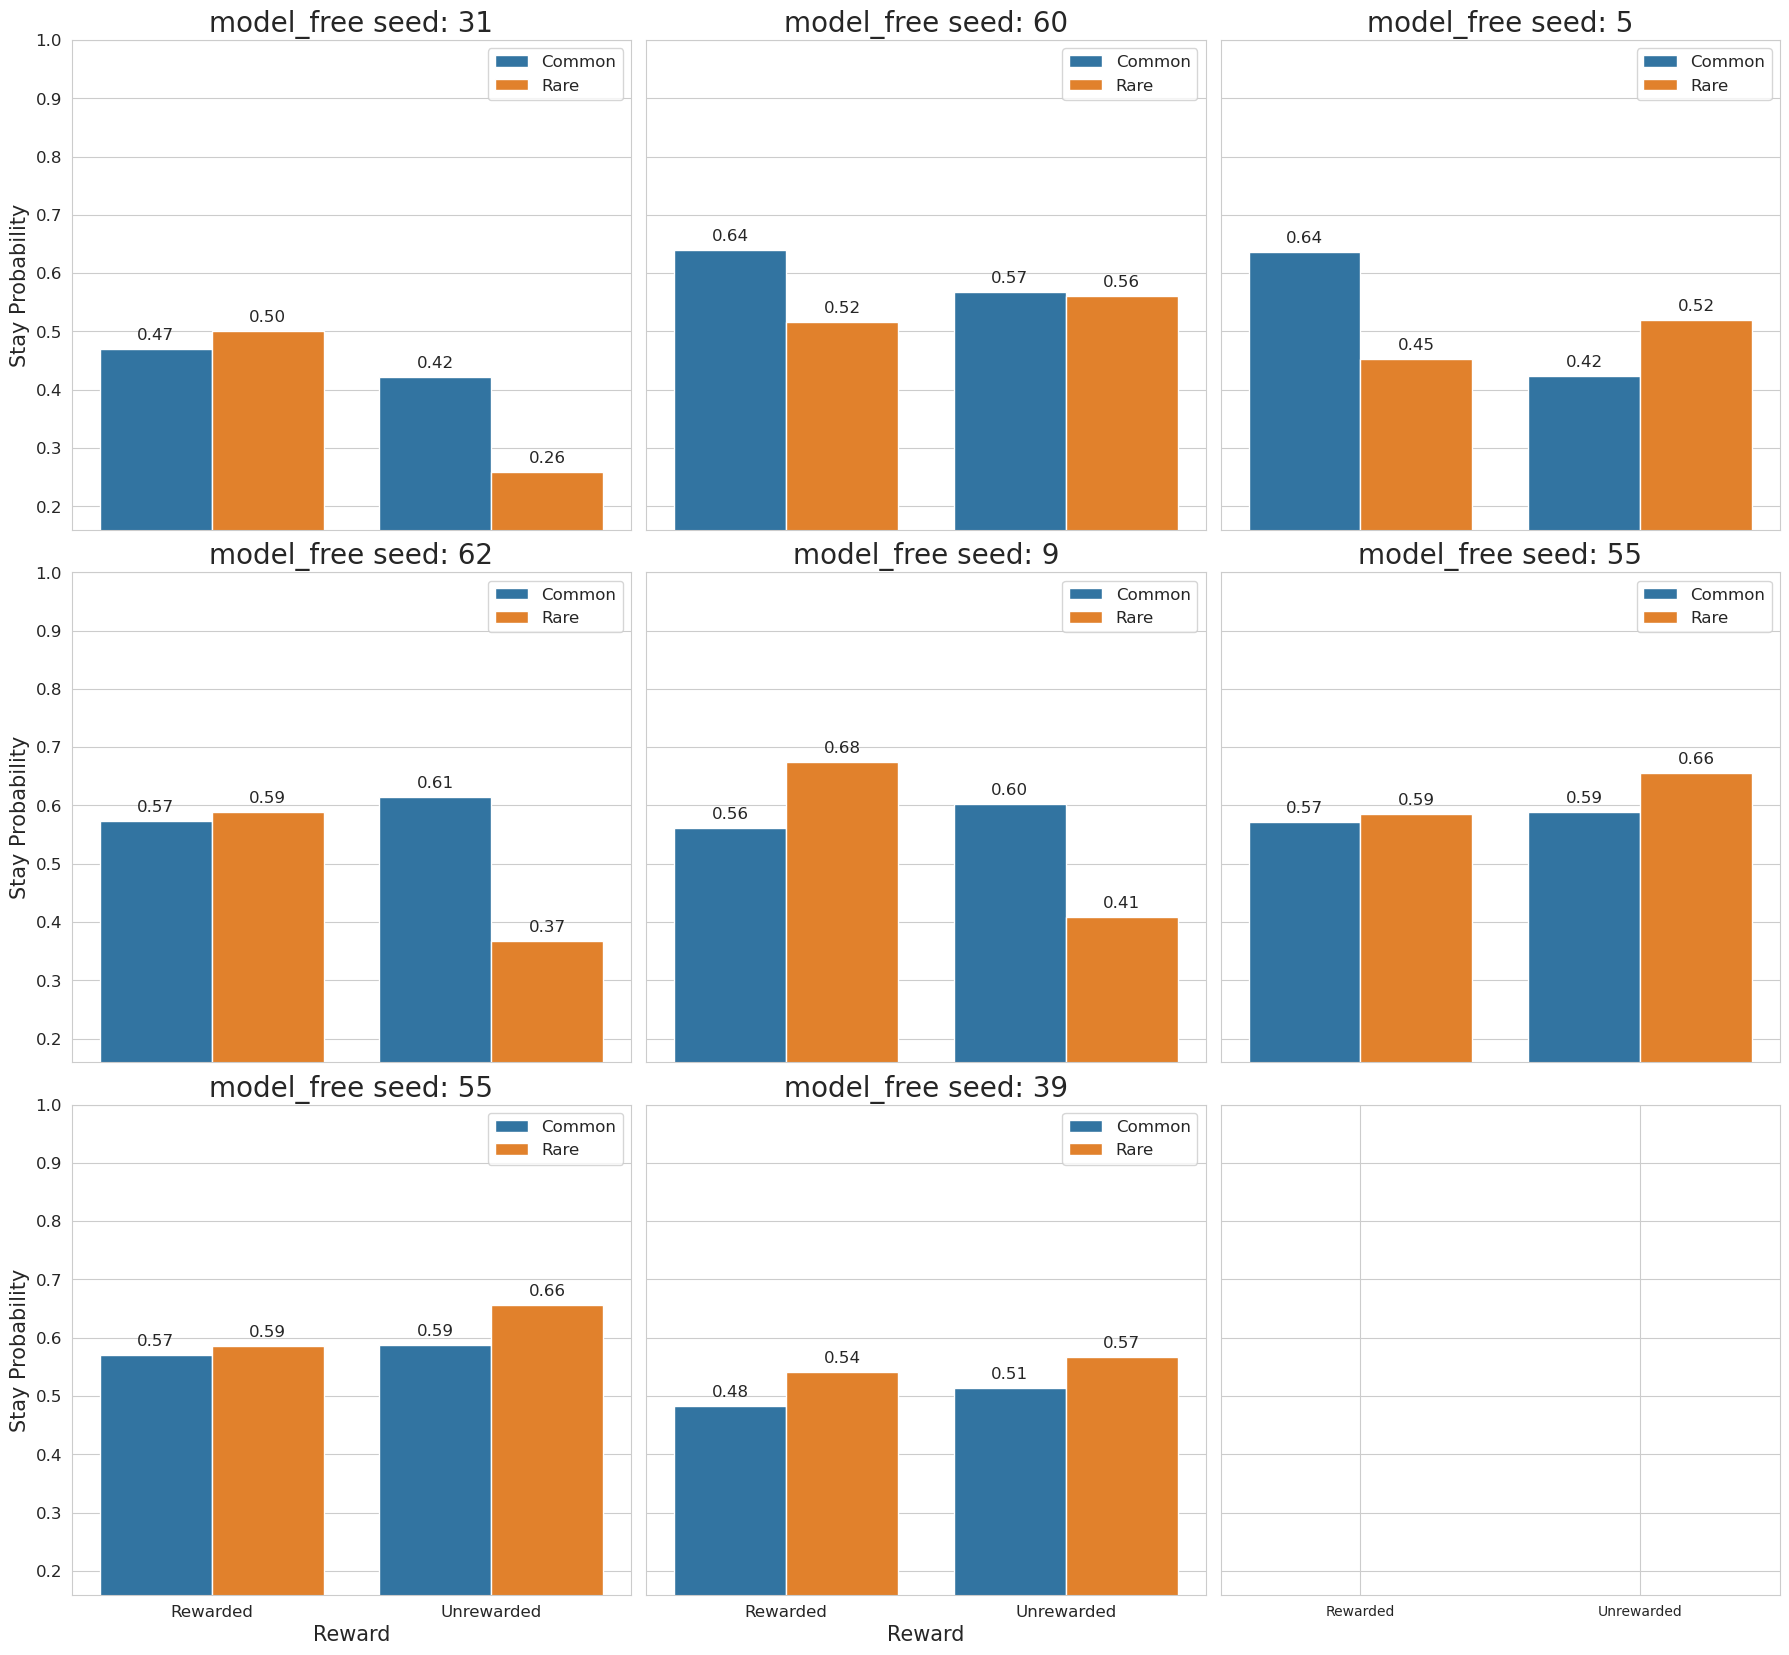

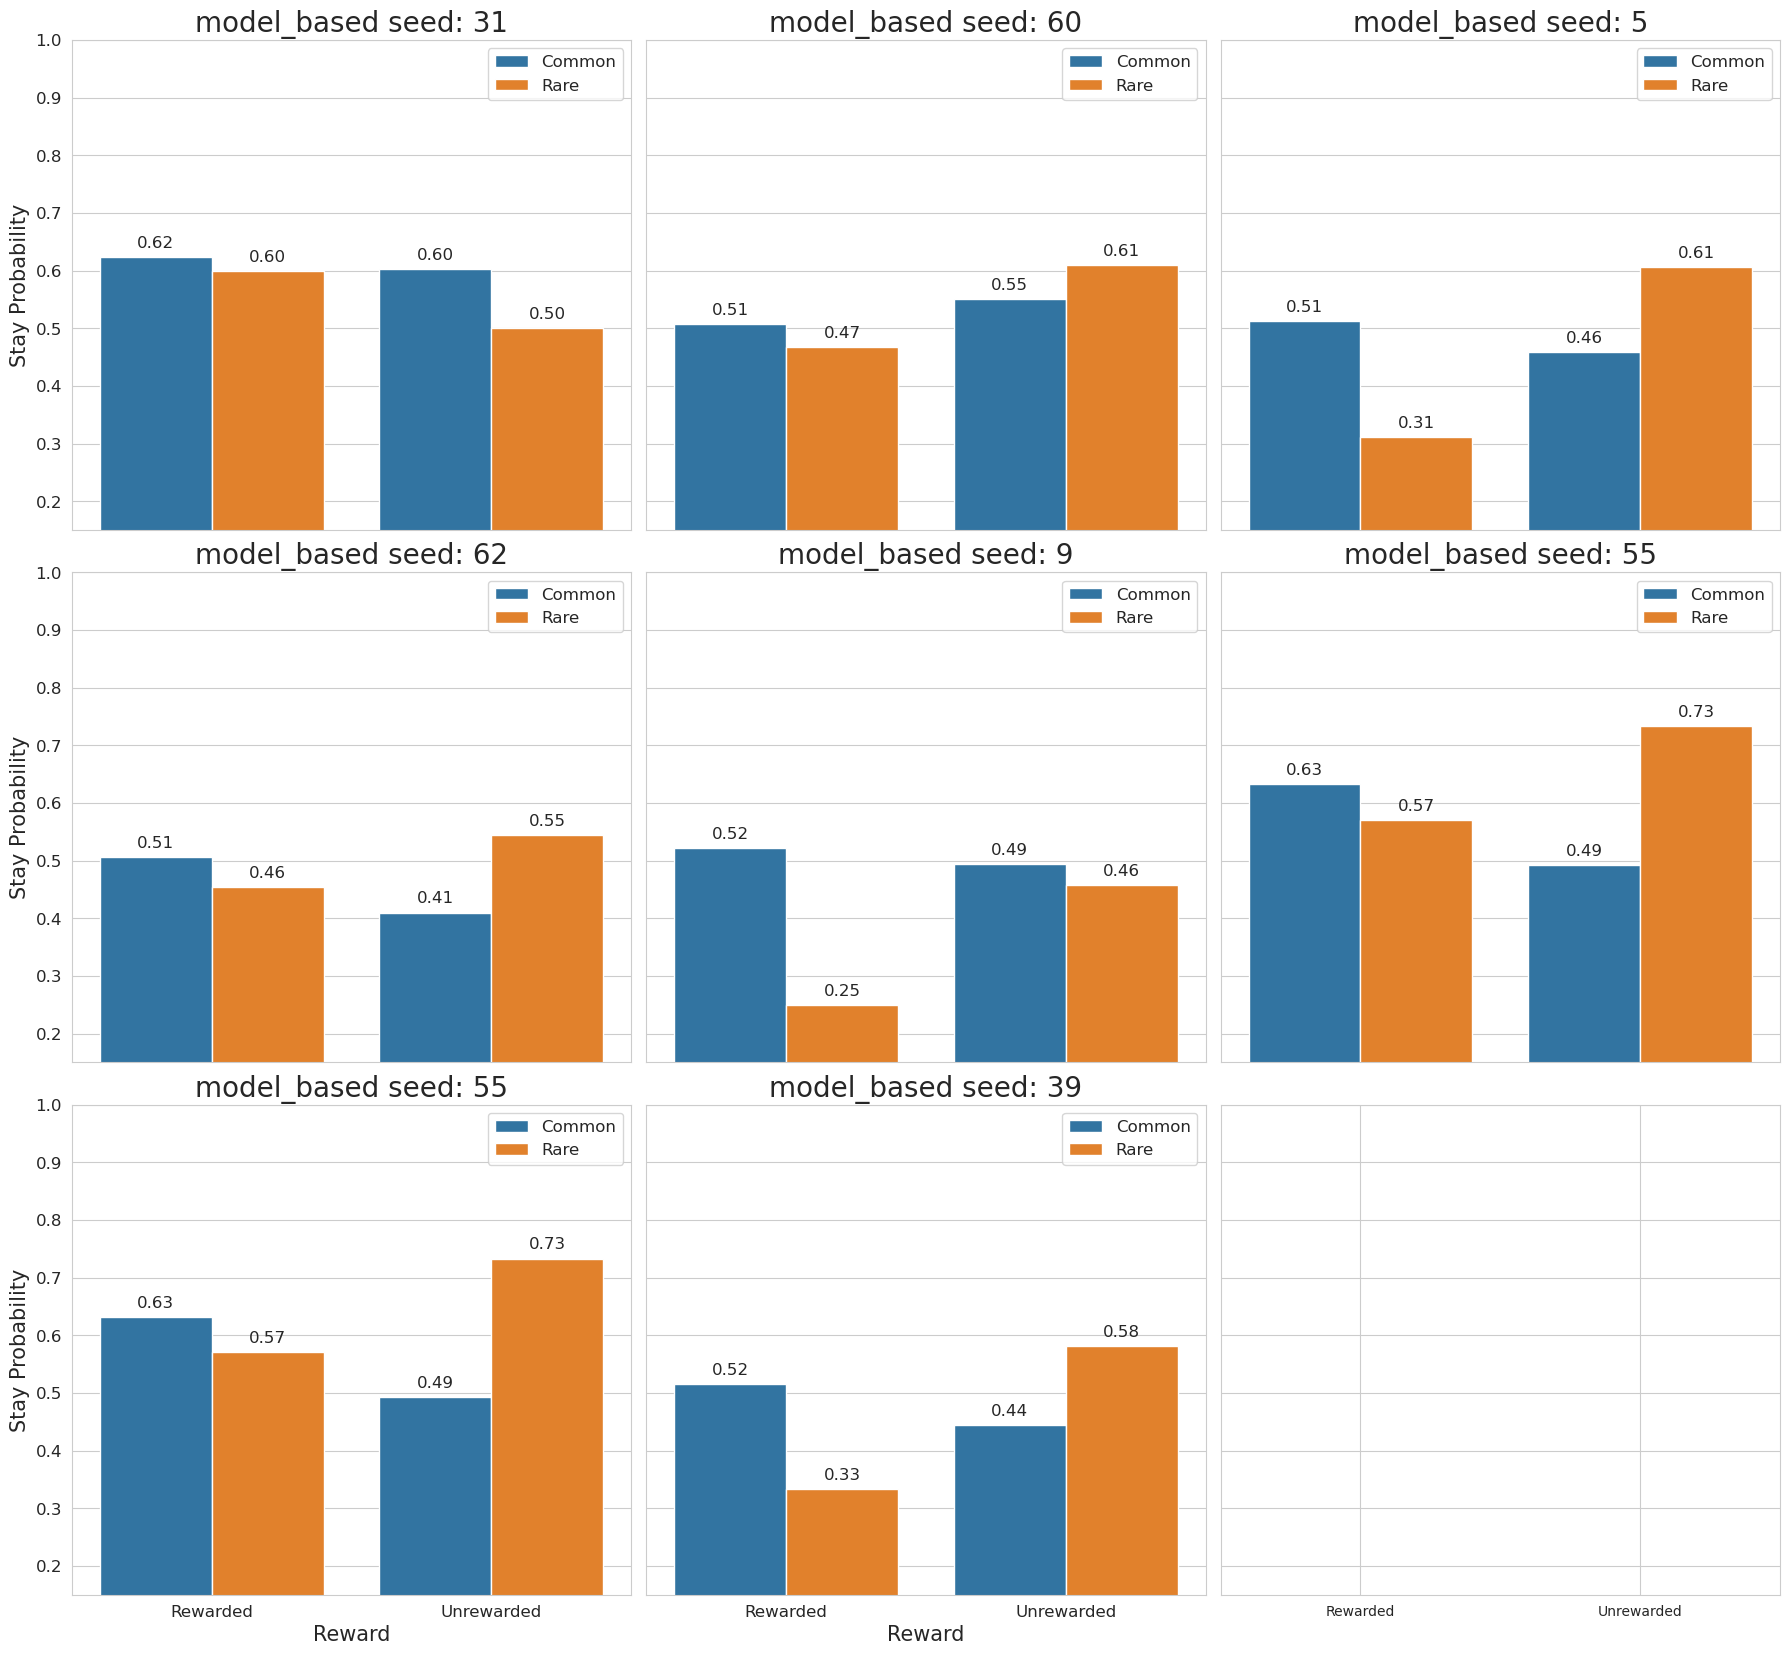

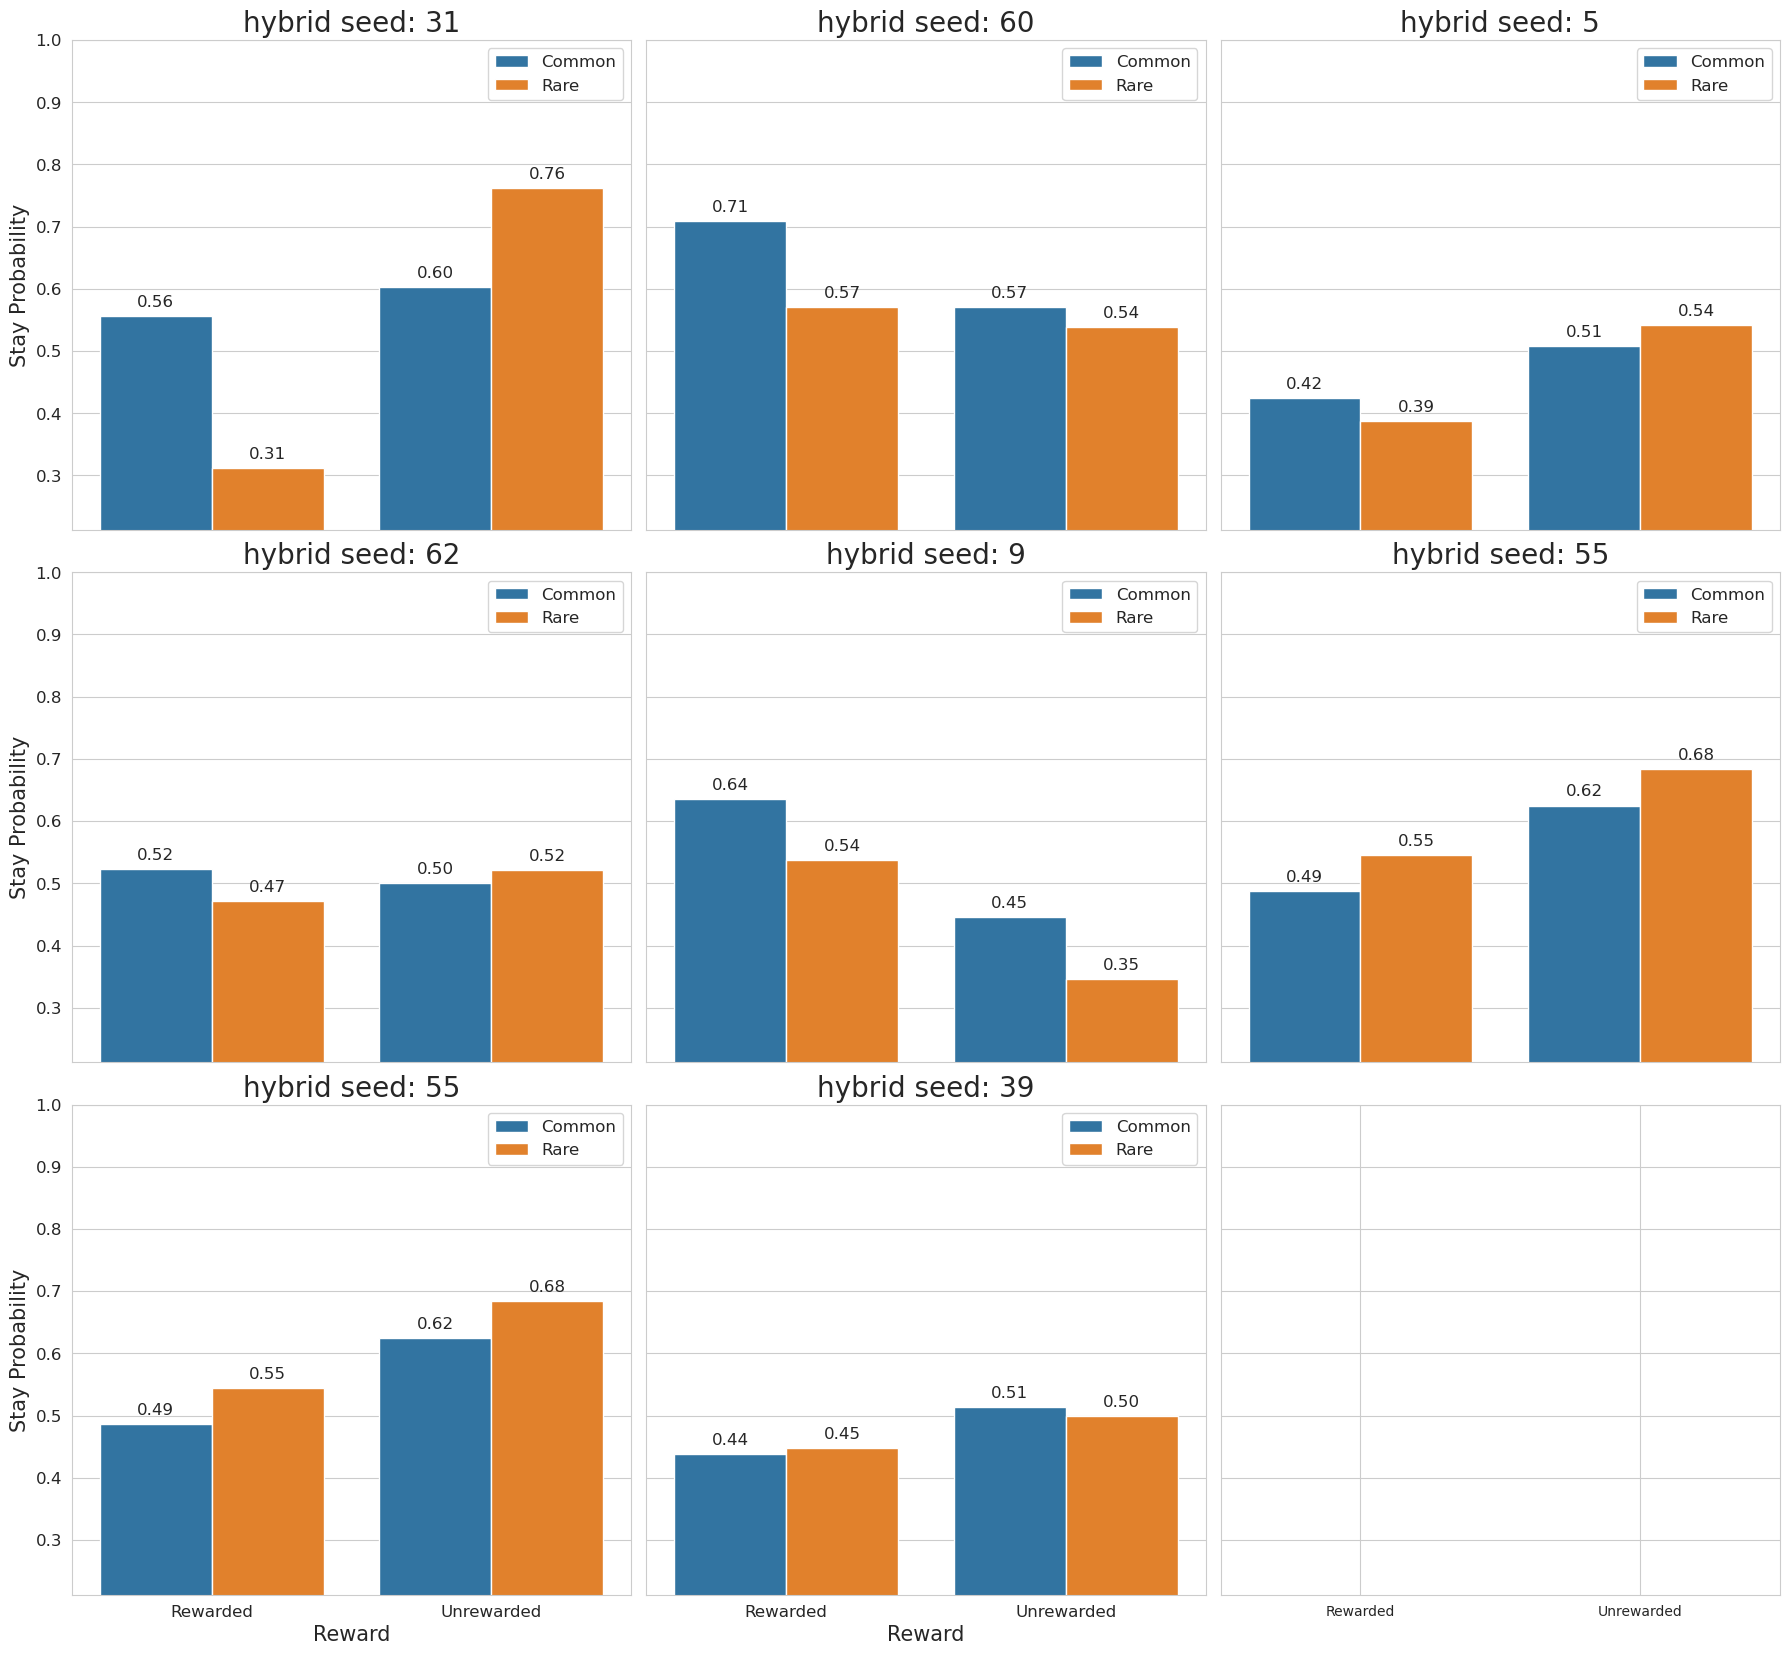

In [11]:
# simualte moltiple times and concatenate the data to average the results
# model_type = 'model_based'
# if model_type == 'model_based':
#     best_params = best_params_mb
# elif model_type == 'model_free':
#     best_params = best_params_mf
# else:
#     print('model type not recognized')

sample_size = 8
sampled_data_mf = []
sampled_data_mb = []
sampled_data_hybrid = []
random_seeds = np.random.randint(sample_size ** 2, size=sample_size)
for seed in random_seeds:
    print(f'seed: {seed}')
    # data_best_mb, agent_best = simulate(model_type, seed=seed, params=best_params)
    data_best_mf, _  = simulate('model_free', seed=seed, params=best_params_mf)
    data_best_mb, _ = simulate('model_based', seed=seed, params=best_params_mb)
    data_best_hybrid, _  = simulate('hybrid', seed=seed, params=best_params_hybrid)

    # print some statistics 
    # print_simple_statistics(data_best_mb, title='model_based')
    # print_simple_statistics(data_best_mf, title='model_free')
    # print_simple_statistics(data_best_hybrid, title='hybrid')

    # calculate and plot stay probability
    stay_probability_df_mf, _ = calculate_stay_probability(data_best_mf)
    stay_probability_df_mb, _ = calculate_stay_probability(data_best_mb)
    stay_probability_df_hybrid, _ = calculate_stay_probability(data_best_hybrid)
    # add to the data
    sampled_data_mf.append(stay_probability_df_mf)
    sampled_data_mb.append(stay_probability_df_mb)
    sampled_data_hybrid.append(stay_probability_df_hybrid)
    print('#'*50)

plot_stay_probabilities(dfs=sampled_data_mf, labels=[f'{"model_free"} seed: {s}' for s in random_seeds], max_plots_per_row=3)
plot_stay_probabilities(dfs=sampled_data_mb, labels=[f'{"model_based"} seed: {s}' for s in random_seeds], max_plots_per_row=3)
plot_stay_probabilities(dfs=sampled_data_hybrid, labels=[f'{"hybrid"} seed: {s}' for s in random_seeds], max_plots_per_row=3)

'model_free'

,Rewarded,Common,Condition,Stay Probability
0,False,False,unrewarded_rare,0.499375
1,False,True,unrewarded_common,0.539875
2,True,False,rewarded_rare,0.555500
3,True,True,rewarded_common,0.562875


'model_based'

,Rewarded,Common,Condition,Stay Probability
0,False,False,unrewarded_rare,0.595750
1,False,True,unrewarded_common,0.493125
2,True,False,rewarded_rare,0.444875
3,True,True,rewarded_common,0.556500


'hybrid'

,Rewarded,Common,Condition,Stay Probability
0,False,False,unrewarded_rare,0.572250
1,False,True,unrewarded_common,0.549000
2,True,False,rewarded_rare,0.477125
3,True,True,rewarded_common,0.532625


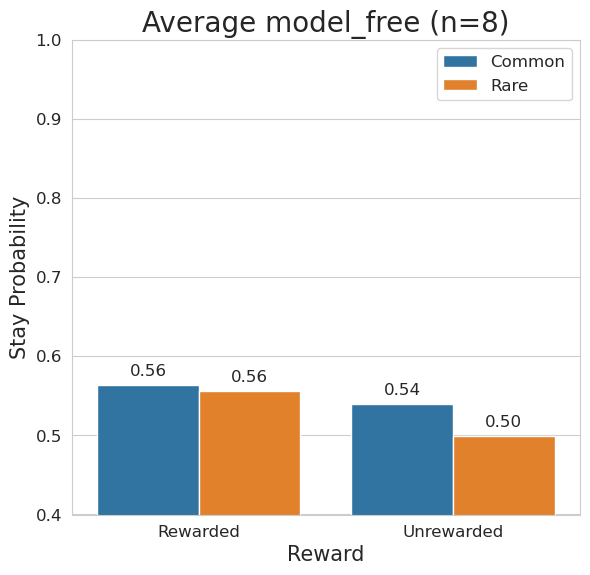

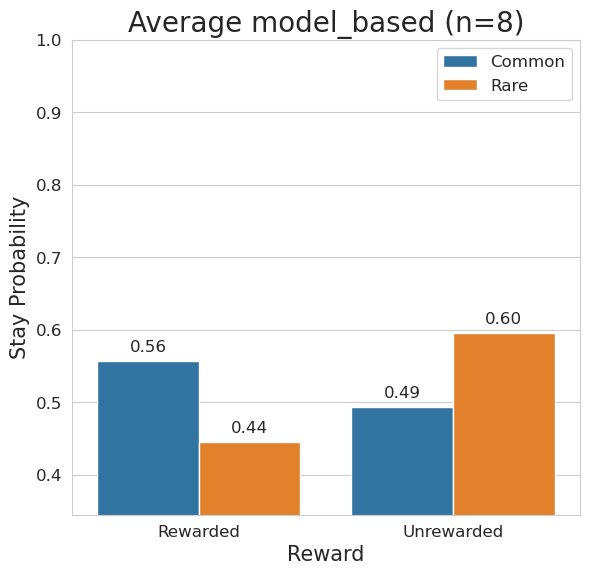

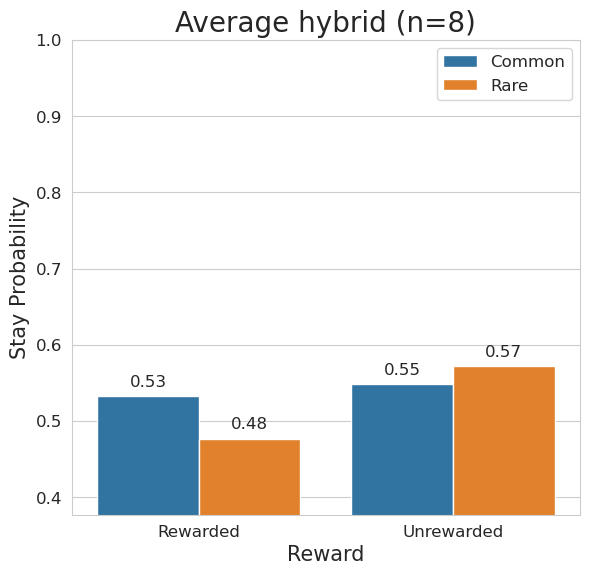

In [16]:
# take the average
all_data_mf = pd.concat(sampled_data_mf).reset_index(drop=True)
all_data_mb = pd.concat(sampled_data_mb).reset_index(drop=True)
all_data_hybrid = pd.concat(sampled_data_hybrid).reset_index(drop=True)
# Compute the average stay probabilities
average_data_mf = all_data_mf.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
average_data_mb = all_data_mb.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
average_data_hybrid = all_data_hybrid.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
# display the average
display('model_free', average_data_mf)
display('model_based', average_data_mb)
display('hybrid', average_data_hybrid)
# plot the average
plot_stay_probabilities(average_data_mf, labels=f'Average {"model_free"} (n={sample_size})')
plot_stay_probabilities(average_data_mb, labels=f'Average {"model_based"} (n={sample_size})')
plot_stay_probabilities(average_data_hybrid, labels=f'Average {"hybrid"} (n={sample_size})')

{'diff_rewarded_rare': -0.007374999999999986, 'diff_unrewarded_rare': -0.040499999999999974, 'diff_rewarded_unrewarded': 0.03312499999999999}
{'diff_rewarded_rare': -0.111625, 'diff_unrewarded_rare': 0.102625, 'diff_rewarded_unrewarded': -0.21425000000000002}


/tmp/ipykernel_102302/3468703245.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45)
/tmp/ipykernel_102302/3468703245.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45)
/tmp/ipykernel_102302/3468703245.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45)


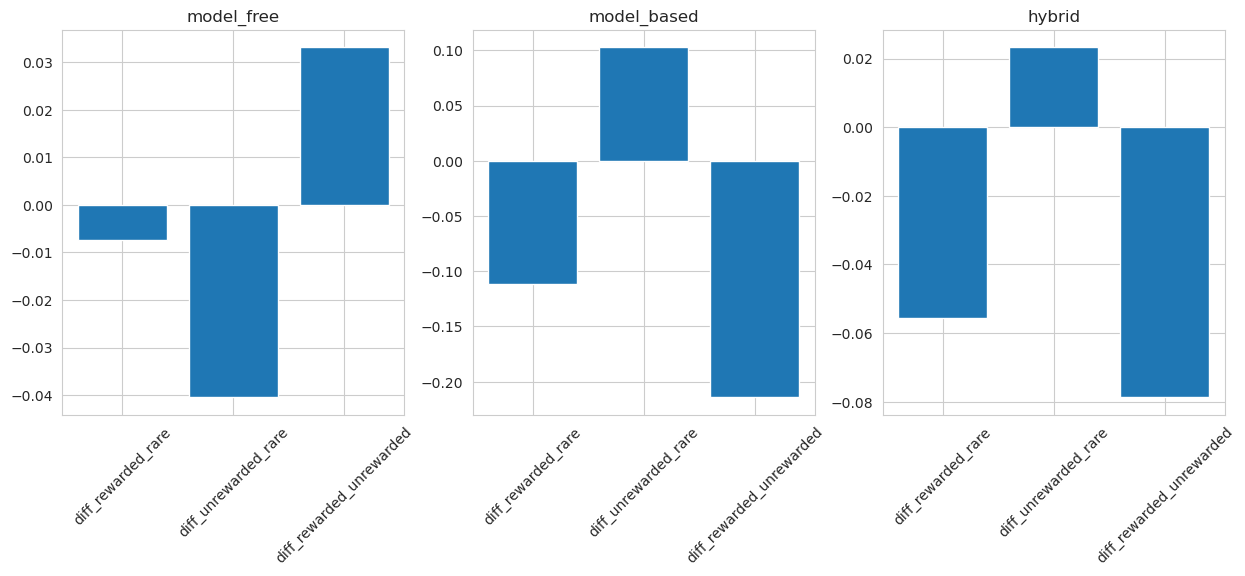

In [13]:
# first take the mean of the differences between rewarded common and rare transitions
# and unrewarded common and rare transitions
# then take the mean of the differences between the differences

# calculate the differences
diffs_mf = []
diffs_mb = []
diffs_hybrid = []
for stay_prob_mf, stay_prob_mb, stay_prob_hybrid in zip(sampled_data_mf, sampled_data_mb, sampled_data_hybrid):
    diff_mf = {}
    rewarded_common = stay_prob_mf.loc[(stay_prob_mf['Rewarded']==True) & (stay_prob_mf['Common']==True), 'Stay Probability'].values[0]
    rewarded_rare = stay_prob_mf.loc[(stay_prob_mf['Rewarded']==True) & (stay_prob_mf['Common']==False), 'Stay Probability'].values[0]
    unrewarded_common = stay_prob_mf.loc[(stay_prob_mf['Rewarded']==False) & (stay_prob_mf['Common']==True), 'Stay Probability'].values[0]
    unrewarded_rare = stay_prob_mf.loc[(stay_prob_mf['Rewarded']==False) & (stay_prob_mf['Common']==False), 'Stay Probability'].values[0]
    diff_mf['rewarded_common'] = rewarded_common
    diff_mf['diff_rewarded_rare'] = rewarded_rare - rewarded_common
    diff_mf['unrewarded_common'] = unrewarded_common
    diff_mf['diff_unrewarded_rare'] = unrewarded_rare - unrewarded_common
    diff_mf['diff_rewarded_unrewarded'] = diff_mf['diff_rewarded_rare'] - diff_mf['diff_unrewarded_rare']
    diffs_mf.append(diff_mf)

    diff_mb = {}
    rewarded_common = stay_prob_mb.loc[(stay_prob_mb['Rewarded']==True) & (stay_prob_mb['Common']==True), 'Stay Probability'].values[0]
    rewarded_rare = stay_prob_mb.loc[(stay_prob_mb['Rewarded']==True) & (stay_prob_mb['Common']==False), 'Stay Probability'].values[0]
    unrewarded_common = stay_prob_mb.loc[(stay_prob_mb['Rewarded']==False) & (stay_prob_mb['Common']==True), 'Stay Probability'].values[0]
    unrewarded_rare = stay_prob_mb.loc[(stay_prob_mb['Rewarded']==False) & (stay_prob_mb['Common']==False), 'Stay Probability'].values[0]
    diff_mb['rewarded_common'] = rewarded_common
    diff_mb['diff_rewarded_rare'] = rewarded_rare - rewarded_common
    diff_mb['unrewarded_common'] = unrewarded_common
    diff_mb['diff_unrewarded_rare'] = unrewarded_rare - unrewarded_common
    diff_mb['diff_rewarded_unrewarded'] = diff_mb['diff_rewarded_rare'] - diff_mb['diff_unrewarded_rare']
    diffs_mb.append(diff_mb)
    
    diff_hybrid = {}
    rewarded_common = stay_prob_hybrid.loc[(stay_prob_hybrid['Rewarded']==True) & (stay_prob_hybrid['Common']==True), 'Stay Probability'].values[0]
    rewarded_rare = stay_prob_hybrid.loc[(stay_prob_hybrid['Rewarded']==True) & (stay_prob_hybrid['Common']==False), 'Stay Probability'].values[0]
    unrewarded_common = stay_prob_hybrid.loc[(stay_prob_hybrid['Rewarded']==False) & (stay_prob_hybrid['Common']==True), 'Stay Probability'].values[0]
    unrewarded_rare = stay_prob_hybrid.loc[(stay_prob_hybrid['Rewarded']==False) & (stay_prob_hybrid['Common']==False), 'Stay Probability'].values[0]
    diff_hybrid['rewarded_common'] = rewarded_common
    diff_hybrid['diff_rewarded_rare'] = rewarded_rare - rewarded_common
    diff_hybrid['unrewarded_common'] = unrewarded_common
    diff_hybrid['diff_unrewarded_rare'] = unrewarded_rare - unrewarded_common
    diff_hybrid['diff_rewarded_unrewarded'] = diff_hybrid['diff_rewarded_rare'] - diff_hybrid['diff_unrewarded_rare']
    diffs_hybrid.append(diff_hybrid)
    

# take the mean of the differences
mean_diffs_mf = {}
# mean_diffs['rewarded_common'] = np.mean([diff['rewarded_common'] for diff in diffs])
# mean_diffs['diff_rewarded_rare'] = mean_diffs['rewarded_common'] + np.mean([diff['diff_rewarded_rare'] for diff in diffs])
mean_diffs_mf['diff_rewarded_rare'] = np.mean([diff['diff_rewarded_rare'] for diff in diffs_mf])

# mean_diffs['unrewarded_common'] = np.mean([diff['unrewarded_common'] for diff in diffs])
# mean_diffs['diff_unrewarded_rare'] = mean_diffs['unrewarded_common'] + np.mean([diff['diff_unrewarded_rare'] for diff in diffs])
mean_diffs_mf['diff_unrewarded_rare'] = np.mean([diff['diff_unrewarded_rare'] for diff in diffs_mf])
mean_diffs_mf['diff_rewarded_unrewarded'] = np.mean([diff['diff_rewarded_unrewarded'] for diff in diffs_mf])
print(mean_diffs_mf)

mean_diffs_mb = {}
# mean_diffs['rewarded_common'] = np.mean([diff['rewarded_common'] for diff in diffs])
# mean_diffs['diff_rewarded_rare'] = mean_diffs['rewarded_common'] + np.mean([diff['diff_rewarded_rare'] for diff in diffs])
mean_diffs_mb['diff_rewarded_rare'] = np.mean([diff['diff_rewarded_rare'] for diff in diffs_mb])

# mean_diffs['unrewarded_common'] = np.mean([diff['unrewarded_common'] for diff in diffs])
# mean_diffs['diff_unrewarded_rare'] = mean_diffs['unrewarded_common'] + np.mean([diff['diff_unrewarded_rare'] for diff in diffs])
mean_diffs_mb['diff_unrewarded_rare'] = np.mean([diff['diff_unrewarded_rare'] for diff in diffs_mb])
mean_diffs_mb['diff_rewarded_unrewarded'] = np.mean([diff['diff_rewarded_unrewarded'] for diff in diffs_mb])
print(mean_diffs_mb)

mean_diffs_hybrid = {}
mean_diffs_hybrid['diff_rewarded_rare'] = np.mean([diff['diff_rewarded_rare'] for diff in diffs_hybrid])
mean_diffs_hybrid['diff_unrewarded_rare'] = np.mean([diff['diff_unrewarded_rare'] for diff in diffs_hybrid])
mean_diffs_hybrid['diff_rewarded_unrewarded'] = np.mean([diff['diff_rewarded_unrewarded'] for diff in diffs_hybrid])

# plot the differences for both
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].bar(mean_diffs_mf.keys(), mean_diffs_mf.values())
ax[0].set_title('model_free')
ax[1].bar(mean_diffs_mb.keys(), mean_diffs_mb.values())
ax[1].set_title('model_based')
ax[2].bar(mean_diffs_hybrid.keys(), mean_diffs_hybrid.values())
ax[2].set_title('hybrid')

# rotate the ticks
for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45)
    
plt.show()


## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [17]:
from parameter_recovery import param_recovery, plot_param_recovery, plot_param_correlation
from parameter_fitting import fit_with_grid_search, fit_with_random_search, get_best_params_and_ll
import numpy as np
import pandas as pd
from scipy.stats import uniform

In [18]:
NUM_RUNS = 20
INTERPOLATION_STEPS = 21
ALPHA_RANGE = (0, 1)
BETA_RANGE = (-2, 10)
SEED = 0

param_space = {'alpha': np.linspace(*ALPHA_RANGE, INTERPOLATION_STEPS),
                'beta': np.linspace(*BETA_RANGE, INTERPOLATION_STEPS)}

In [20]:
# parameter recovery for the model free agent
fitted_params_mf, true_params_mf, best_ll_mf_list = param_recovery(agent_type='model_free',
                                                        parameter_space=param_space,
                                                        fit_type='grid_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=SEED)

fitting_runs::   0%|          | 0/20 [00:00<?, ?it/s]

fitting_runs:: 100%|██████████| 20/20 [02:42<00:00,  8.10s/it]


In [21]:
# # parameter recovery for the model based agent
fitted_params_mb, true_params_mb, best_ll_mb_list = param_recovery(agent_type='model_based',
                                                        parameter_space=param_space,
                                                        fit_type='grid_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=SEED)

fitting_runs:: 100%|██████████| 20/20 [04:09<00:00, 12.50s/it]


In [22]:
# parameter recovery for the hybrid agent 

param_distributions = {
    'alpha_1': uniform(0, 1),
    'alpha_2': uniform(0, 1),
    'beta_1': uniform(-10, 10),
    'beta_2': uniform(-10, 10),
    '_lambda': uniform(0.0, 1.0),
    'w': uniform(0.0, 1.0),
    'p': uniform(-1, 2),
}

# agent_type:str, parameter_space:dict, fit_function:Callable, num_runs:int=20, seed:int=0
fitted_params_hybrid, true_params_hybrid, best_ll_hybrid_list = param_recovery(agent_type='hybrid',
                                                        parameter_space=param_distributions,
                                                        fit_type='random_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=0)

fitting_runs:: 100%|██████████| 20/20 [01:09<00:00,  3.50s/it]


Pearson correlation for alpha: 0.739, p_value: 0.00019697659399448488
Pearson correlation for beta: 0.969, p_value: 2.333899921773982e-12


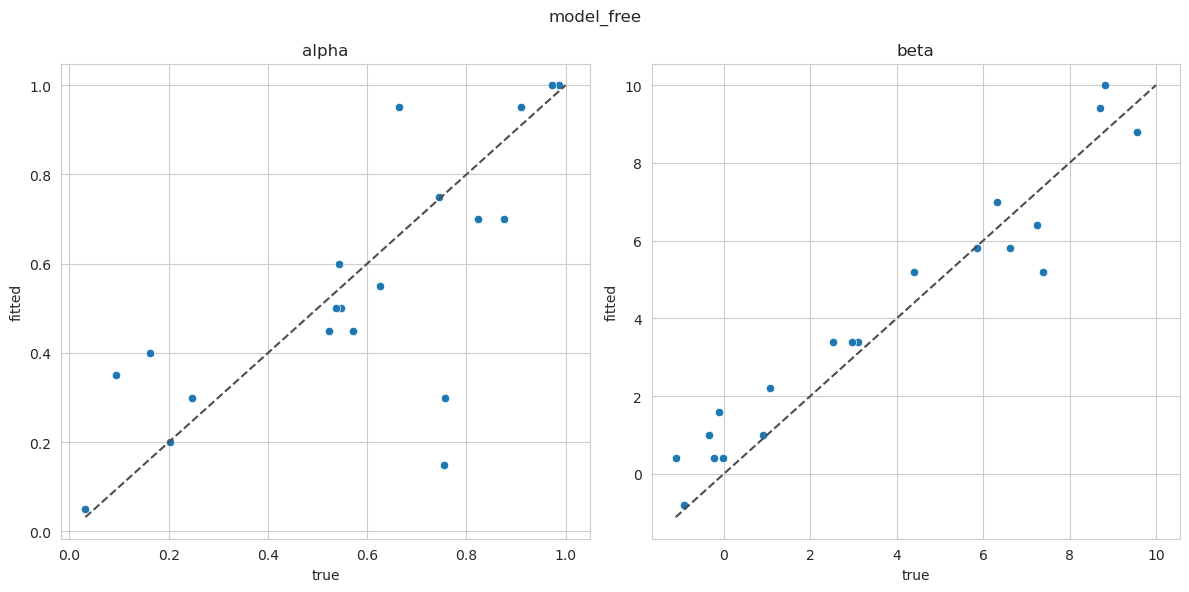

Pearson correlation for alpha: 0.835, p_value: 4.614320306663707e-06
Pearson correlation for beta: 0.765, p_value: 8.563479686325871e-05


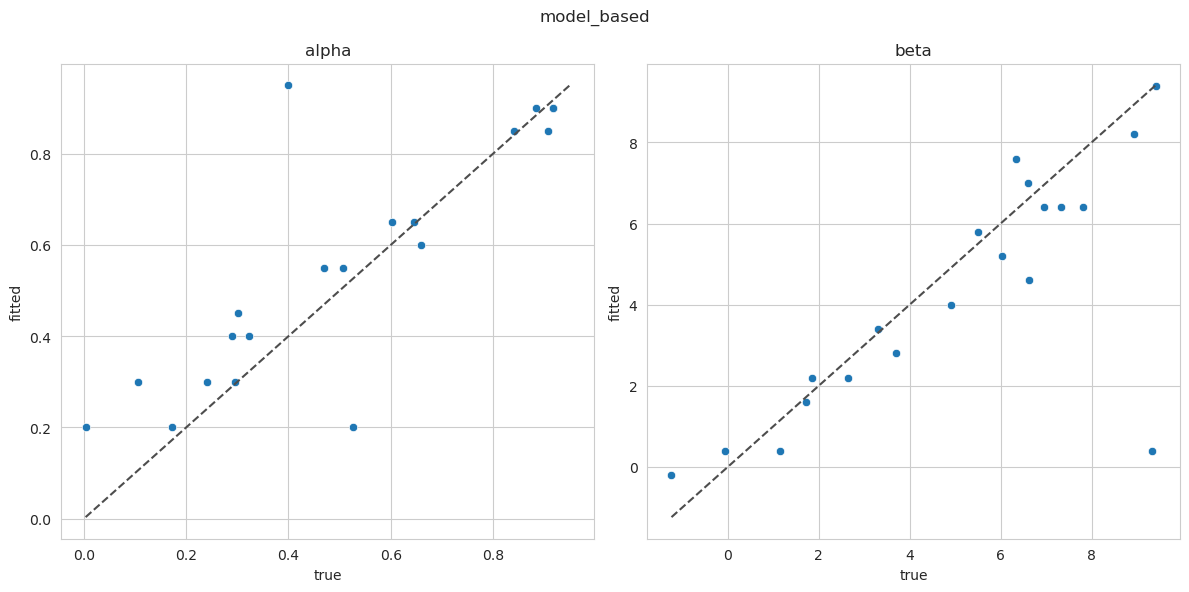

Pearson correlation for alpha_1: 0.245, p_value: 0.2969279576181411
Pearson correlation for alpha_2: 0.879, p_value: 3.3064439889732936e-07
Pearson correlation for beta_1: 0.278, p_value: 0.2352809518592373
Pearson correlation for beta_2: 0.781, p_value: 4.755893853981784e-05
Pearson correlation for _lambda: -0.138, p_value: 0.5609464821555588
Pearson correlation for w: 0.240, p_value: 0.30714894691376693
Pearson correlation for p: 0.686, p_value: 0.0008335453678207705


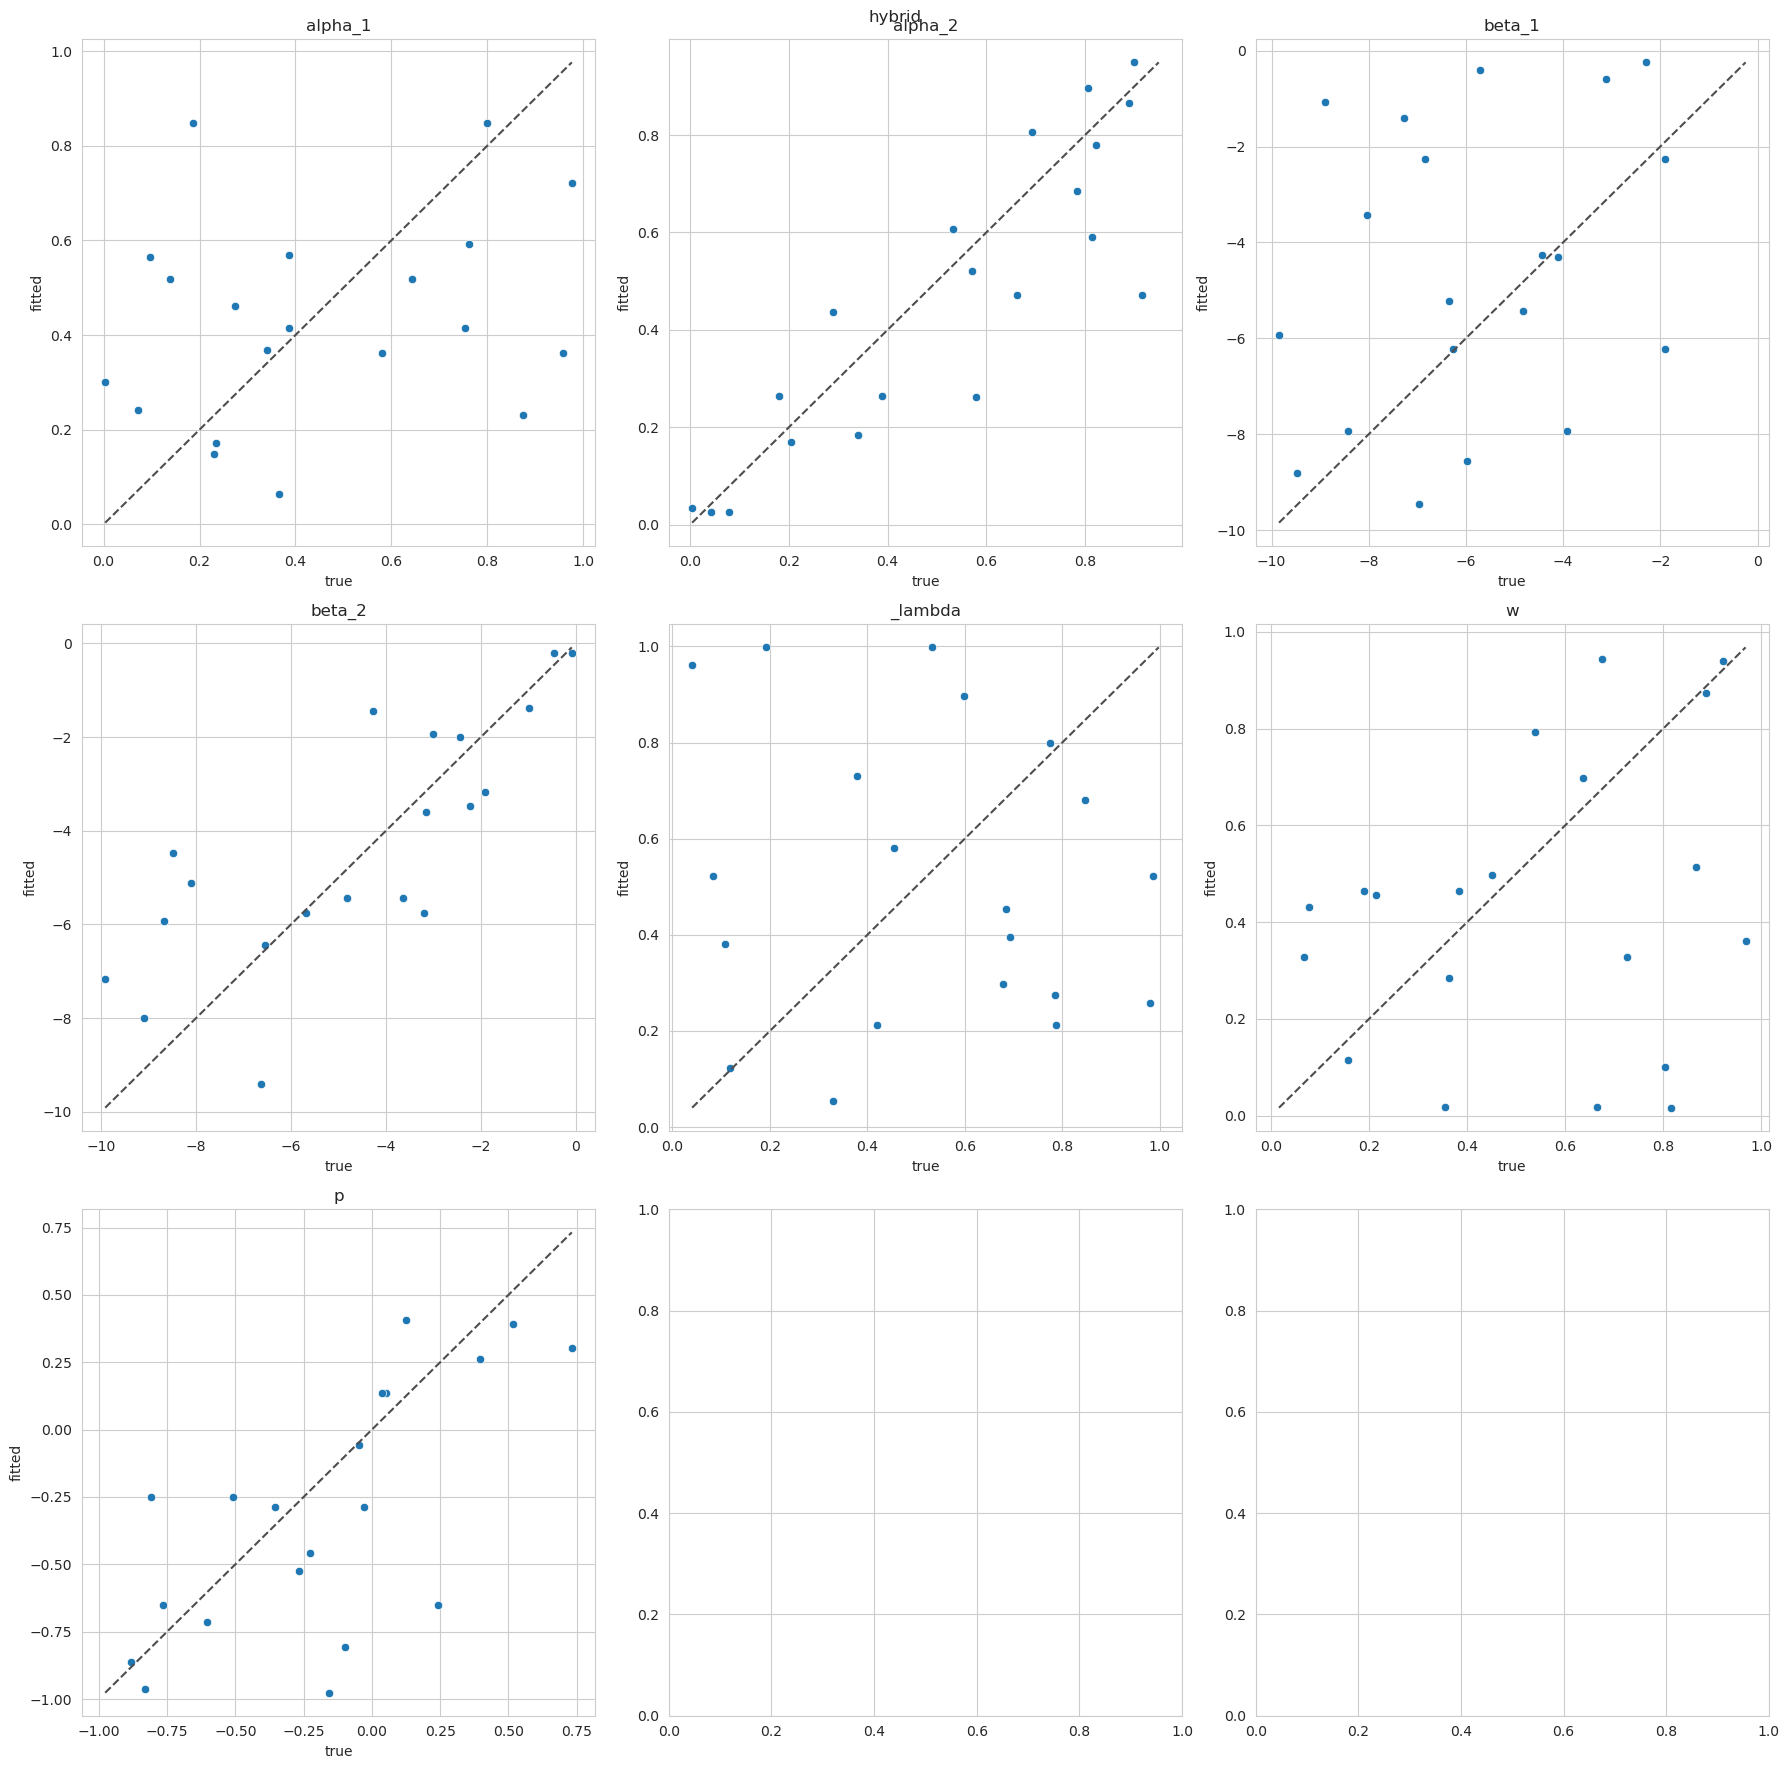

In [23]:
# plot the results
plot_param_recovery(true_params_mf, fitted_params_mf, 'model_free')
plot_param_recovery(true_params_mb, fitted_params_mb, 'model_based')
plot_param_recovery(true_params_hybrid, fitted_params_hybrid, 'hybrid')

corr_1: PearsonRResult(statistic=0.16906150215944593, pvalue=0.476131725349612)


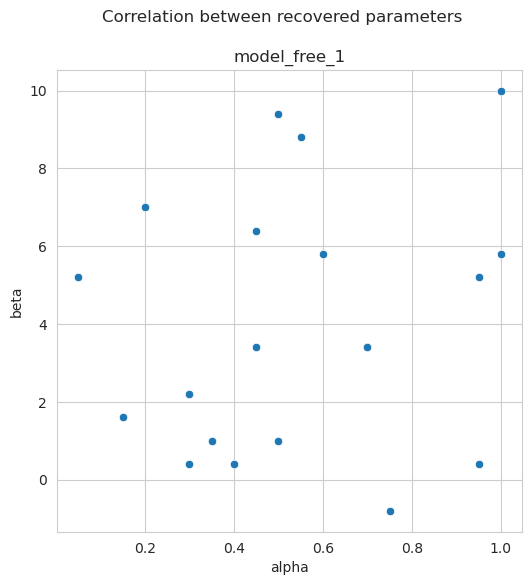

corr_1: PearsonRResult(statistic=0.31749365774171223, pvalue=0.17255074130384743)


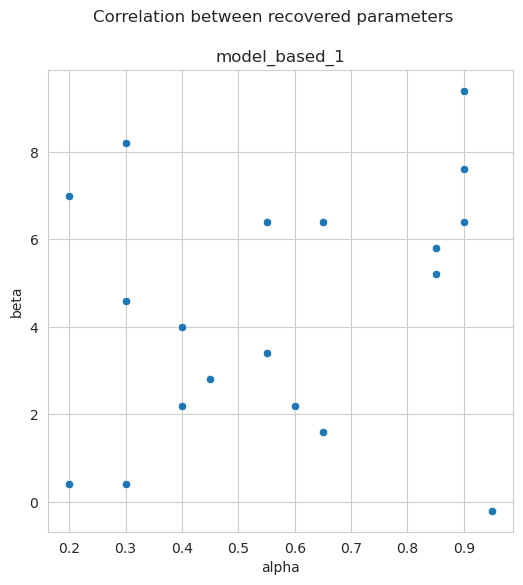

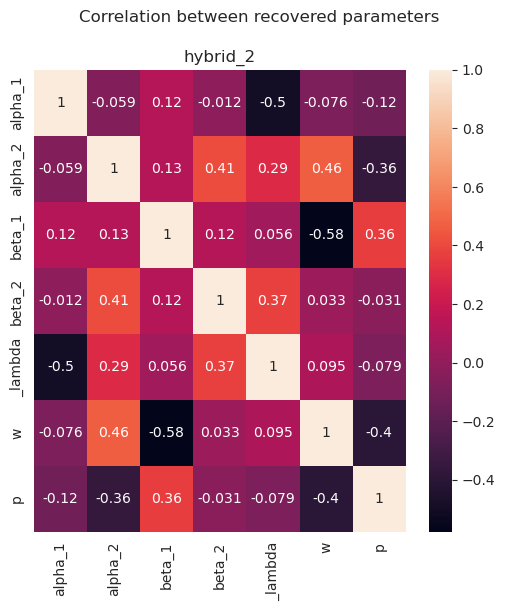

In [24]:
# plot recovered parameters correlation
plot_param_correlation(fitted_params_mf, 'model_free')
plot_param_correlation(fitted_params_mb, 'model_based')
plot_param_correlation(fitted_params_hybrid, 'hybrid')

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [25]:
# YOUR MODEL RECOVERY CODE GOES HERE

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [30]:
from utils import calculate_bic

num_datapoints = len(human_data)

bic_mf = calculate_bic(num_params=2, num_data_points=num_datapoints, ll=best_ll_mf)
bic_mb = calculate_bic(num_params=2, num_data_points=num_datapoints, ll=best_ll_mb)
bic_hybrid = calculate_bic(num_params=7, num_data_points=num_datapoints, ll=best_ll_hybrid)

print(f'BIC model free: {bic_mf}')
print(f'BIC model based: {bic_mb}')
print(f'BIC hybrid: {bic_hybrid}')

results_bic = pd.DataFrame({'model': ['model_free', 'model_based', 'hybrid'],
                            'bic': [bic_mf, bic_mb, bic_hybrid],
                            'll': [best_ll_mf, best_ll_mb, best_ll_hybrid],
                            'num_parameters': [2, 2, 7]})
display(results_bic)
model_with_lowest_bic = results_bic.loc[results_bic['bic'].idxmin(), 'model']
print(f'The model with the lowest BIC is: {model_with_lowest_bic}')

BIC model free: 495.5571921912955
BIC model based: 501.8500856289778
BIC hybrid: 597.8204577515185


,model,bic,ll,num_parameters
0,model_free,495.557192,-242.480279,2
1,model_based,501.850086,-245.626725,2
2,hybrid,597.820458,-280.366118,7


The model with the lowest BIC is: model_free


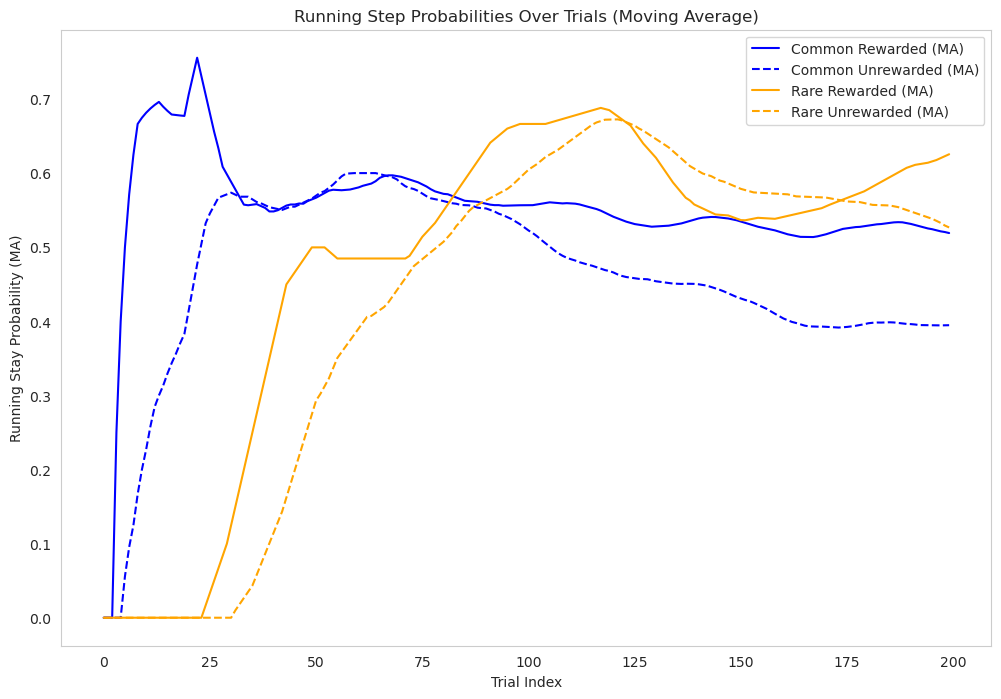

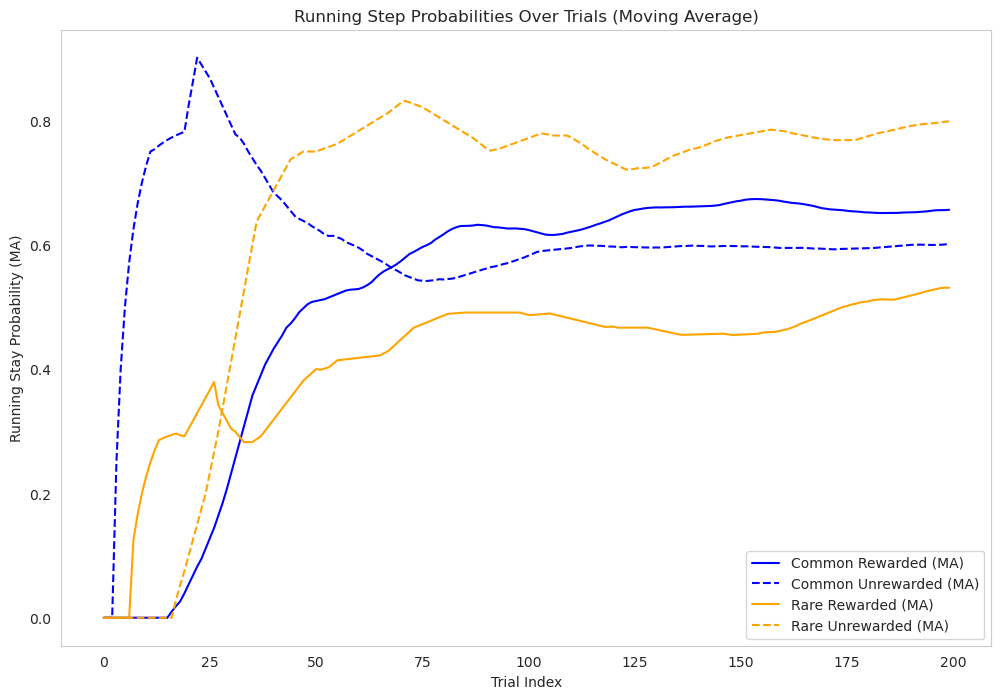

In [31]:
from utils import calculate_running_step_probabilities, plot_running_step_probabilities

task_dfs = {'model_free': task_df_mf, 'model_based': task_df_mb, 'hybrid': task_df_hybrid}

# Generate behavior from the model
behavior = calculate_running_step_probabilities(task_dfs[model_with_lowest_bic])
plot_running_step_probabilities(behavior, window_size=20)

# Generate behavior from the human data
human_data_probs = calculate_running_step_probabilities(human_data)
plot_running_step_probabilities(human_data_probs, window_size=20)